In [92]:
import scipy.io as sio
import yaml
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from torch import nn

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

configuration = yaml.safe_load(open('config.yaml'))
data_path= configuration["data"]



### Helper functions

In [93]:
def load_data(ds:str):
    """ Load data from the dataset specified by the user"""
    data = sio.loadmat(data_path[ds]["img"])
    labels = sio.loadmat(data_path[ds]["labels"])
    return data[list(data.keys())[-1]], labels[list(labels.keys())[-1]]

def extract_random_pixel(X, label):
    long, larg, depth = X.shape
    assert long == label.shape[0] and larg == label.shape[1]
    x = np.random.randint(long)
    y = np.random.randint(larg)
    return (X[x, y, :], label[x, y])

def balanced_split(y):
    """Returns the mask for a balanced split train-test"""
    classes = np.unique(y)
    unsup_mask = (y==0) # some pixels are not that usefull : did not get any label

    train_mask = (y==-1) # false everywhere, shaped as y
    test_mask = (y==-1) # false everywhere, shaped as y

    for i in classes:
        if i>0:
            col, rows = np.where(y==i)
            col_train, col_test, row_train, row_test = train_test_split(col, rows, test_size=0.2)
            train_mask[col_train, row_train] = True
            test_mask[col_test, row_test] = True
    return train_mask, test_mask, unsup_mask

def extract_tiles(X, number, w):

    patches_top_left_corners = [(np.random.randint(X.shape[0]-w), np.random.randint(X.shape[1]-w)) for i in range(number)]
    X_patches = []
    y_patches = []
    for a, b in patches_top_left_corners:
        X_patches.append(X[a:a+w, b:b+w, :])
    return np.array(X_patches)


In [14]:
X1, y1 = load_data("KSC")
X2, y2 = load_data("IP")
X3, y3 = load_data("PU")

print(X1.shape, y1.shape, X2.shape, y2.shape, X3.shape, y3.shape)

X, y= X1, y1

(512, 614, 176) (512, 614) (145, 145, 220) (145, 145) (610, 340, 103) (610, 340)


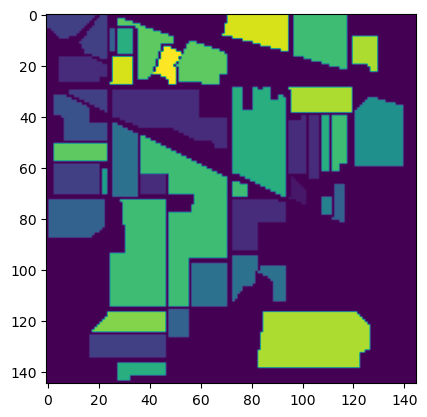

In [4]:
plt.imshow(y2)

In [5]:
extract_random_pixel(X1, y1)

(array([ 71, 105,  96,  99, 109, 117, 120, 128, 133, 140, 146, 149, 158,
        167, 170, 174, 177, 172, 179, 178, 186, 186, 187, 188, 194, 191,
        194, 194, 184, 183, 188, 197, 218, 241, 249, 263, 275, 287, 271,
        284, 293, 297, 299, 300, 287, 295, 310, 316, 316, 315, 318, 322,
        329, 332, 326, 332, 317, 300, 306, 302, 320, 328, 336, 339, 344,
        350, 351, 352, 352, 348, 347, 362, 367, 379, 393, 374, 347, 334,
        309, 354, 332, 330, 327, 329, 323, 330, 333, 338, 338, 334, 307,
        305, 340, 304, 328, 351, 377, 233, 240, 237, 270, 282, 267, 275,
        278, 282, 286, 289, 292, 288, 295, 299, 304, 311, 316, 318, 314,
        317, 318, 315, 312, 313, 307, 300, 302, 292, 294, 305, 307, 281,
        302, 162, 129, 194, 225, 221, 211, 211, 218, 234, 235, 235, 242,
        238, 237, 238, 241, 241, 238, 241, 241, 236, 244, 243, 242, 230,
        227, 217, 210, 208, 195, 194, 198, 181, 189, 186, 172, 186, 194,
        194, 179, 184, 170, 161, 167, 143], dtype=u

In [6]:
values1 = np.unique(y1, return_counts=True)
values2 = np.unique(y2, return_counts=True)
values3 = np.unique(y3, return_counts=True)

In [7]:
train_mask1, test_mask1, unsup_mask1 = balanced_split(y1)
train_mask2, test_mask2, unsup_mask2 = balanced_split(y2)

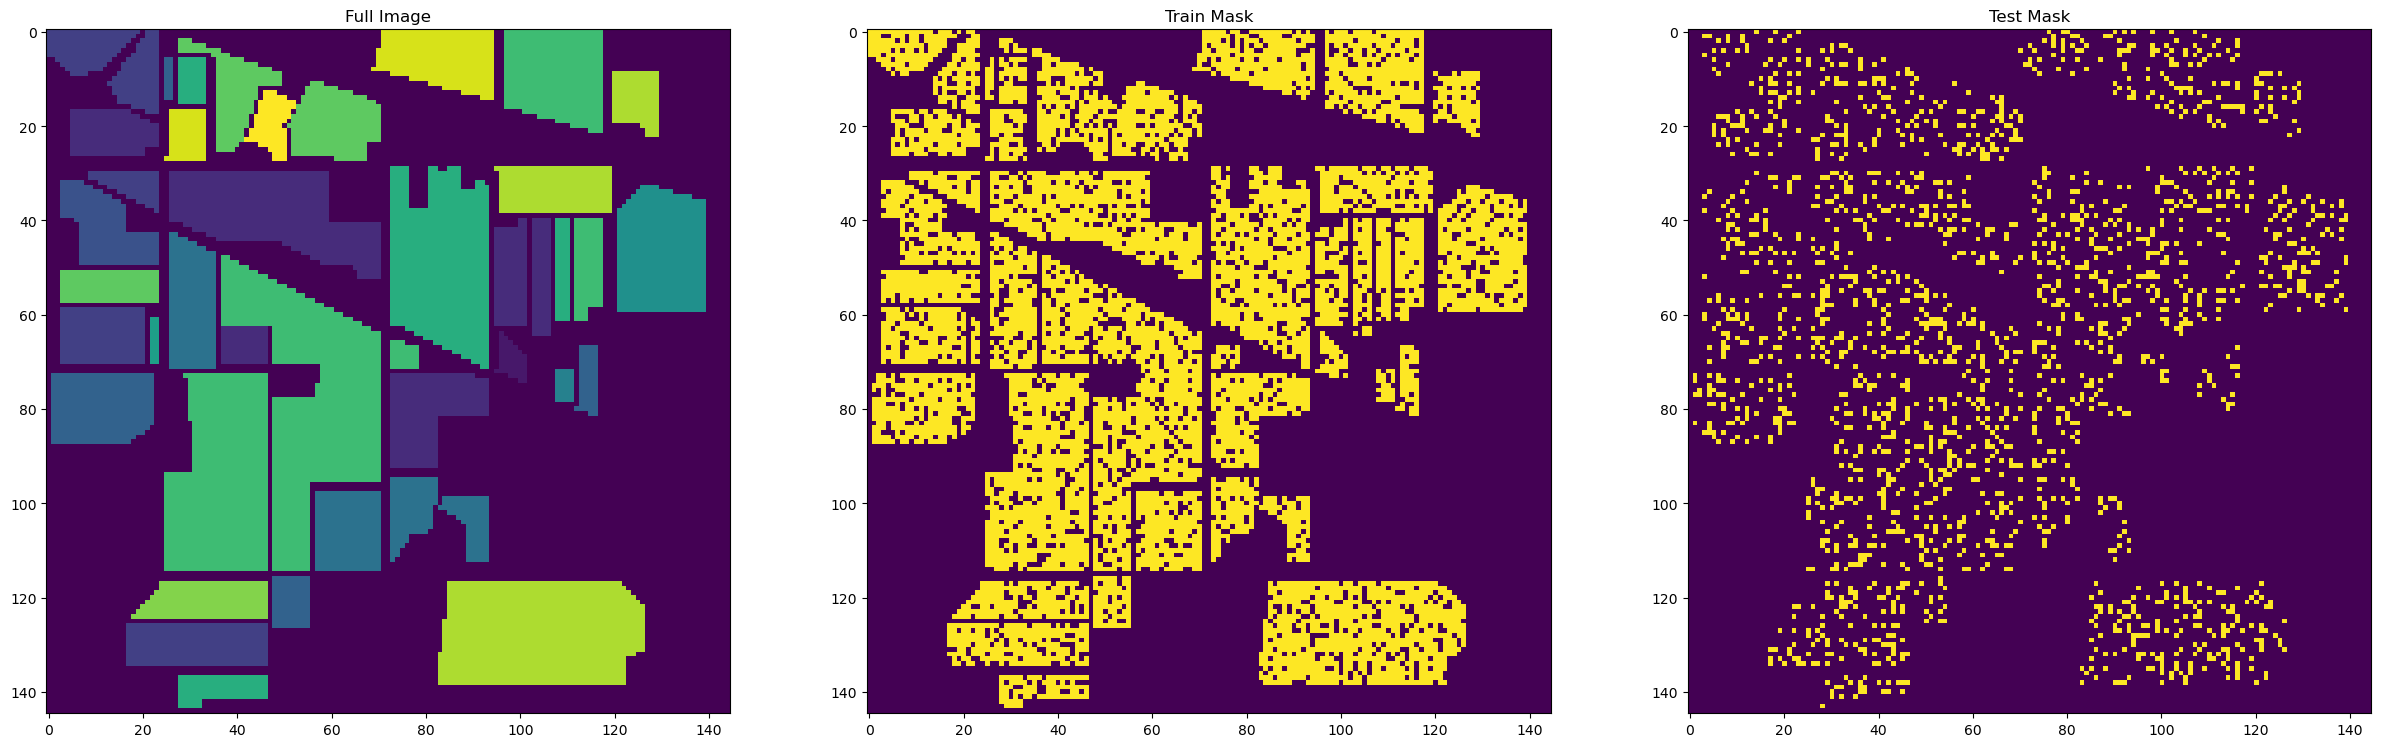

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
ax[0].imshow(y2)
ax[0].title.set_text("Full Image")
ax[1].imshow(train_mask2)
ax[1].title.set_text("Train Mask")
ax[2].imshow(test_mask2)
ax[2].title.set_text("Test Mask")

# paper replication

In [9]:
# CONSTATNS for RPNet-RF:
parameters = {
    "p" : 4, # number of PC in PCA
    "L" : 4, # network depth
    "k" : 50, # number of patches
    "w" : 15, # size of patches
    "delta_s" : 50, # spatial standard deviation
    "delta_r" : .5 # Range standard deviation
}
p = 4 # number of PC in PCA
L = 4 # network depth
k = 50 # number of patches
w = 15 # size of patches
delta_s = 50 # spatial standard deviation
delta_r = 0.5 # Range standard deviation


In [10]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA



### Patch extraction:

In [12]:
pca = PCA(n_components=p*10)
pca_white = PCA(n_components=p, whiten=True)

In [152]:
A = X.reshape(X.shape[0]*X.shape[1], -1)

In [154]:
B = pca_white.fit_transform(A).reshape(X.shape[0], X.shape[1], p)

In [157]:
X.shape

(512, 614, 176)

In [133]:
pca.singular_values_.shape

(40,)

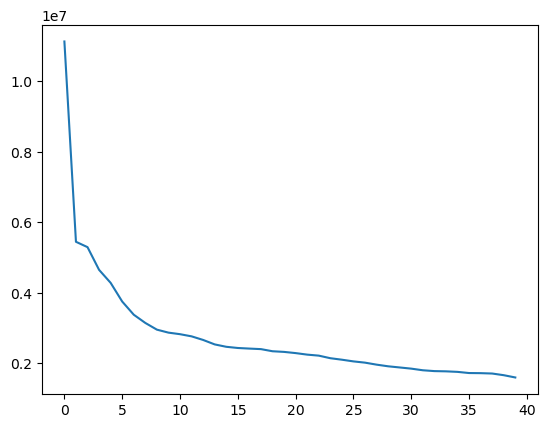

In [134]:
plt.plot(pca.singular_values_)

In [149]:
extract_tiles(X1, y1, 50, 15)[0].shape

(50, 15, 15, 176)

In [355]:
def RPNet_extractor(X, y, params = parameters):
    """ Feature extraction using RPNet method"""

    p = params["p"] # number of PC in PCA
    L = params["L"] # network depth
    k = params["k"] # number of patches
    w = params["w"] # size of patches
    long, larg, prof = X.shape[0], X.shape[1], X.shape[2]

    feature_maps = []
    # L times feature extraction with convolutionn filters
    for i in range(L):

        # Scale and center the data, then apply pca to it
        scaler = StandardScaler()
        pca_white = PCA(n_components=p, whiten=True)
        A = X.reshape(long * larg, -1)
        A = scaler.fit_transform(A)
        feat_map = pca_white.fit_transform(A).reshape(long, larg, p)

        # extract patches:
        patches = extract_tiles(feat_map, k, w)
        patches_tensor = torch.from_numpy(patches).unsqueeze(1)
        res = nn.functional.conv3d(torch.from_numpy(feat_map).to(torch.float32).unsqueeze(0),
                                weight=patches_tensor.to(torch.float32),
                                bias=None,
                                padding=(w//2, w//2, 0),
                                dilation=1,
                                groups=1)
                

        extracted_map = res.squeeze(0).squeeze(-1).permute(1,2,0)

        feature_maps.append(extracted_map)

    feature_maps_tensor= torch.cat(feature_maps, dim=2)

    # final PCA to find the right number of PC ("Q" in the paper)

    pca = PCA()
    S = StandardScaler()
    feature_maps_tensor = S.fit_transform(feature_maps_tensor.reshape(-1, L*k))
    pca.fit(feature_maps_tensor)
    Q = pca.explained_variance_ratio_.cumsum().searchsorted(0.9995, side="right")

    print(f"We keep {Q+1} principal componnents to keep 99.95% of the variance.")
    pca = PCA(n_components=Q+1)
    extracted_maps = pca.fit_transform(feature_maps_tensor)
    
    return extracted_maps.reshape(long, larg, -1)


In [356]:
tensor = RPNet_extractor(X1, y1, parameters)